# Task 1: Data Understanding and Preparation

## Introduction and Dataset Description

This notebook contains an explorative analysis of the "customer_supermarket" dataset describing purchases and shopping sessions.

The data is organised in a form of an array, where the dataset attributes (aka features) are organised in columns, and the shoppig sessions (aka instances) in rows. The dataset consists of several data categories describing the purchases performed by the customers (i.e. the id of the virtual basket associated with the purchase, the id and description of the product purchased, the time and date when the transaction took place, etc.).

The dataset includes 471910 data observations.

**Importing libraries and loading dataset**

In [2]:
%matplotlib inline
import math

import numpy as np
import pandas as pd

import scipy.stats as stats
from scipy.stats import pearsonr

import matplotlib.pyplot as plt
import seaborn as sn

import collections
from collections import defaultdict


**Loading the dataset**

Read the .csv file containing the data. The first line contains the list of attributes. The data is assigned to a Pandas dataframe.

In [3]:
df = pd.read_csv('dataset/customer_supermarket.csv', sep='\t', index_col=0)

## Data Semantics

The pandas function **head()** provides some of the first records of the dataframe. <br>We use it in order to assess the correct loading of the dataset and to provide a example of the records contained within it.

In [4]:
print(df.head()) #print the first records of a df

  BasketID      BasketDate  Sale  CustomerID CustomerCountry  ProdID  \
0   536365  01/12/10 08:26  2,55     17850.0  United Kingdom  85123A   
1   536365  01/12/10 08:26  3,39     17850.0  United Kingdom   71053   
2   536365  01/12/10 08:26  2,75     17850.0  United Kingdom  84406B   
3   536365  01/12/10 08:26  3,39     17850.0  United Kingdom  84029G   
4   536365  01/12/10 08:26  3,39     17850.0  United Kingdom  84029E   

                             ProdDescr  Qta  
0   WHITE HANGING HEART T-LIGHT HOLDER    6  
1                  WHITE METAL LANTERN    6  
2       CREAM CUPID HEARTS COAT HANGER    8  
3  KNITTED UNION FLAG HOT WATER BOTTLE    6  
4       RED WOOLLY HOTTIE WHITE HEART.    6  


### Types of attributes

The pandas function **info()** is used in order to obtain preliminary information on the dataset. <br>It highlights the data type and counts the number of not-null values for each column of the dataset.

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 471910 entries, 0 to 541909
Data columns (total 8 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   BasketID         471910 non-null  object 
 1   BasketDate       471910 non-null  object 
 2   Sale             471910 non-null  object 
 3   CustomerID       406830 non-null  float64
 4   CustomerCountry  471910 non-null  object 
 5   ProdID           471910 non-null  object 
 6   ProdDescr        471157 non-null  object 
 7   Qta              471910 non-null  int64  
dtypes: float64(1), int64(1), object(6)
memory usage: 32.4+ MB


The aforementioned function, other than identifying **471910** as the number of records contained within the dataframe, highlights:

1. the <u>inability of Pandas to recognize</u> the values of *BasketDate* as <u>datetime</u>;
2. the <u>misinterpretation of the values of the attribute *Sale*</u>, being represented as objects and not real numbers, due to the use of the comma as delimiter for decimal values;
3. the presence of <u>missing values</u> within the attributes *CustomerID* and *ProdDescr*;
4. the presence of <u>non numerical values</u> within the attributes *BasketID* and *ProductID*, despite an expectation at a first intuitive level could suggest them to be integer.

Here we present a classification of these attributes by type:

- Categorical Attributes:<br>
    - *BasketID* - ***String***
    - *CustomerID* - ***Float*** right now, then ***String***
    - *CustomerCountry* - ***String***
    - *ProdID* - ***String***
    - *ProdDescr* - ***String***


- Numerical Attributes:<br>
    - *BasketDate* - ***String*** right now, then ***Datetime***
    - *Sale* - ***String*** right now, then ***Float***
    - *Qta*- ***Int***

### Type Conversions

Now we address the first two issues referred above, we want Pandas to:
+ recognize the values from *BasketDate* as datetime and, 
+ recognize the values from *Sale* as floats.

Both of them are fixable by tinkering with the arguments **parse_dates** and **decimal** from the pandas function **read_csv()** as in :

In [6]:
# df = pd.read_csv('customer_supermarket.csv', sep='\t', index_col=0, decimal = ",",
#                 parse_dates=["BasketDate"])

But, for the sake of this notebook, we will make use of the casting functions provided by Pandas.

#### Converting *BasketDate*
We use the pandas function **to_datetime()** in order to correctly format the values from *BasketDate*.

In [7]:
df['BasketDate'] = pd.to_datetime(df['BasketDate']) # converting 'BasketDate' to datetime

#### Converting *Sale*
The presence of commas as decimal delimiters is common when working with European data.

We substitute the commas with dots in the *Sale* column and convert it from object to float type using pandas function **astype()**.

In [8]:
df['Sale'] = df['Sale'].str.replace(',', '.') # replacing commas with dots
df['Sale'] = df['Sale'].astype(float) # converting 'Sale' to float type

#### Converting CustomerID

Right now the value from the *CustomerID* attribute are represented as floats. 

However, given the index role of *CustomerID*, its representation as a numeric data is not useful for our analysis. The pandas function **astype()** is, therefore, used to cast the values from said attribute as objects. 

In [9]:
df['CustomerID'] = df['CustomerID'].astype(object) # converting 'CustomerID' to object type

#### Summary on the types of attributes after the conversions

In [10]:
df.dtypes # return the type of each attribute

BasketID                   object
BasketDate         datetime64[ns]
Sale                      float64
CustomerID                 object
CustomerCountry            object
ProdID                     object
ProdDescr                  object
Qta                         int64
dtype: object

## Data Statistics

The pandas function **describe()** is used to obtain basic statistical notions regarding the numerical attributes of the dataset.

In [11]:
pd.options.display.float_format = '{:.2f}'.format
df.describe() # this function provides a summary of statistical informations

,Sale,Qta
count,471910.00,471910.00
mean,4.03,10.72
std,83.77,231.36
min,-11062.06,-80995.00
25%,1.25,1.00
50%,2.08,4.00
75%,3.75,12.00
max,38970.00,80995.00


The data provided by the function highlight:
- both *Sale* and *Qta* as positively skewed.
- the presence of **negative values** within both columns, again, *Sale* and *Qta* .
- an high variance for both attributes, perhaps due to the presence of **outliers**.

### Negative values in *Sale* and *Qta*

Trying to contextualize the presence of records containing such values within the dataset, we briefly check their value for the *ProdDescr* attribute.
A deeper analysis concerning the possibility of outliers does still take place in the section **Assessing and Improving Data Quality**. 

#### Sale

We compute a list of the records with negative values for *Sale*.

In [12]:
# Negative values in Sale
df[df.Sale < 0]

,BasketID,BasketDate,Sale,CustomerID,CustomerCountry,ProdID,ProdDescr,Qta
299983,A563186,2011-12-08 14:51:00,-11062.06,NaN,United Kingdom,B,Adjust bad debt,1
299984,A563187,2011-12-08 14:52:00,-11062.06,NaN,United Kingdom,B,Adjust bad debt,1


In [13]:
df[df.Sale < 0].ProdDescr

299983    Adjust bad debt
299984    Adjust bad debt
Name: ProdDescr, dtype: object

According to the description associated with both records (*ProdDescr* : "Adjust bad dept"), these transactions could be associated with some kind of refund operation.
    

Anyway, the statistical significance that these two isolated cases have with respect to the analysis of the dataset in question is minimal if compared to the remaining amount of data. <br>Considering these two records as **outliers**, could therefore **improve the total reliability of the remaining tests** conducted on the dataset.

As already mentioned, the further discussion about removing them continues in the section **Assessing and Improving Data Quality**.

#### Qta

We compute a list of the records with negative values for *Qta*.

In [14]:
# Negative values in Qta
df[df.Qta < 0].head()

,BasketID,BasketDate,Sale,CustomerID,CustomerCountry,ProdID,ProdDescr,Qta
141,C536379,2010-01-12 09:41:00,27.50,14527.00,United Kingdom,D,Discount,-1
154,C536383,2010-01-12 09:49:00,4.65,15311.00,United Kingdom,35004C,SET OF 3 COLOURED FLYING DUCKS,-1
235,C536391,2010-01-12 10:24:00,1.65,17548.00,United Kingdom,22556,PLASTERS IN TIN CIRCUS PARADE,-12
236,C536391,2010-01-12 10:24:00,0.29,17548.00,United Kingdom,21984,PACK OF 12 PINK PAISLEY TISSUES,-24
237,C536391,2010-01-12 10:24:00,0.29,17548.00,United Kingdom,21983,PACK OF 12 BLUE PAISLEY TISSUES,-24


In [15]:
df[df.Qta < 0].ProdDescr

141                               Discount
154        SET OF 3 COLOURED  FLYING DUCKS
235         PLASTERS IN TIN CIRCUS PARADE 
236       PACK OF 12 PINK PAISLEY TISSUES 
237       PACK OF 12 BLUE PAISLEY TISSUES 
                        ...               
540449     ZINC T-LIGHT HOLDER STARS SMALL
541541                              Manual
541715          VICTORIAN SEWING BOX LARGE
541716    HANGING HEART JAR T-LIGHT HOLDER
541717       36 PENCILS TUBE RED RETROSPOT
Name: ProdDescr, Length: 9752, dtype: object

This time the records with a negative value for *Qta* are over 9000 and this amount does guarantee a stronger statistical relevance with respect to the analysis of the dataset.

The values of *ProdDescr* associated with these records, however, don't provide any contextualization for the values of *Qta*.
The best hypothesis remains that one of transactions during which the company acquired some asset from the customers instead of selling it to them.

#### Other interesting considerations: high and symmetrical values in Qta

The *min* and *max* values displayed by the **describe()** function for the *Qta* highlight and interesting dynamic concerning couples of records with high and opposite values for *Qta*. 
The list below contains two of such couples.  

In [16]:
df[df.Qta.apply(abs) > 10000]

,BasketID,BasketDate,Sale,CustomerID,CustomerCountry,ProdID,ProdDescr,Qta
61619,541431,2011-01-18 10:01:00,1.04,12346.00,United Kingdom,23166,MEDIUM CERAMIC TOP STORAGE JAR,74215
61624,C541433,2011-01-18 10:17:00,1.04,12346.00,United Kingdom,23166,MEDIUM CERAMIC TOP STORAGE JAR,-74215
502122,578841,2011-11-25 15:57:00,0.00,13256.00,United Kingdom,84826,ASSTD DESIGN 3D PAPER STICKERS,12540
540421,581483,2011-09-12 09:15:00,2.08,16446.00,United Kingdom,23843,"PAPER CRAFT , LITTLE BIRDIE",80995
540422,C581484,2011-09-12 09:27:00,2.08,16446.00,United Kingdom,23843,"PAPER CRAFT , LITTLE BIRDIE",-80995


Within each of these couples, the record with the negative value for Qta displays a BasketID containing the letter 'C'. 
We therefore compute a list of each record displaying a similar BasketID and a negative value for Qta.

In [17]:
df[(df.BasketID.str.contains('C')) & (df.Qta < 0)]

,BasketID,BasketDate,Sale,CustomerID,CustomerCountry,ProdID,ProdDescr,Qta
141,C536379,2010-01-12 09:41:00,27.50,14527.00,United Kingdom,D,Discount,-1
154,C536383,2010-01-12 09:49:00,4.65,15311.00,United Kingdom,35004C,SET OF 3 COLOURED FLYING DUCKS,-1
235,C536391,2010-01-12 10:24:00,1.65,17548.00,United Kingdom,22556,PLASTERS IN TIN CIRCUS PARADE,-12
236,C536391,2010-01-12 10:24:00,0.29,17548.00,United Kingdom,21984,PACK OF 12 PINK PAISLEY TISSUES,-24
237,C536391,2010-01-12 10:24:00,0.29,17548.00,United Kingdom,21983,PACK OF 12 BLUE PAISLEY TISSUES,-24
...,...,...,...,...,...,...,...,...
540449,C581490,2011-09-12 09:57:00,0.83,14397.00,United Kingdom,23144,ZINC T-LIGHT HOLDER STARS SMALL,-11
541541,C581499,2011-09-12 10:28:00,224.69,15498.00,United Kingdom,M,Manual,-1
541715,C581568,2011-09-12 11:57:00,10.95,15311.00,United Kingdom,21258,VICTORIAN SEWING BOX LARGE,-5
541716,C581569,2011-09-12 11:58:00,1.25,17315.00,United Kingdom,84978,HANGING HEART JAR T-LIGHT HOLDER,-1


We assume the meaning of these couples as some kind of refund activity after a purchase. The presence of another record, with a positive and opposite value of Qta, for each of the components of this list is expected due to this theory.

We aim to drop each of these couples or, in alternative, to sum up the discordant values of Qta within a single record. Said procedure will help to avoid future interferences when computing the number of items, or distinct items, purchased by a customer and will be addressed within the section '**Assessing and Improving Data Quality**'.    

### Data Distributions

#### BasketID

We calculate the total number of distinct values for the attribute BasketID contained within the records from the dataset.

In [18]:
len(df.BasketID.unique())

24627

#### BasketDate

We analyze the distribution of the BasketDate attribute by grouping up the records from the same week, here expressed by its number (from 1 to 52).  

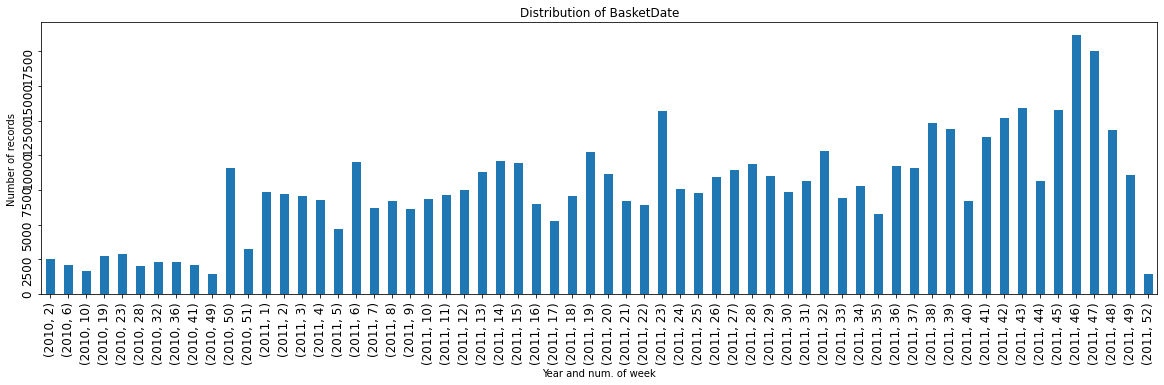

In [19]:
plt.figure(figsize=(20, 5))
df['BasketDate'].groupby([df.BasketDate.dt.year, df.BasketDate.dt.week]).agg('count').plot(kind="bar")
plt.title("Distribution of BasketDate")
plt.xlabel("Year and num. of week")
plt.ylabel("Number of records")
plt.tick_params(labelrotation=90, labelsize='large')
plt.show()

We now provide a deeper insight regarding the distribution of the records among years.

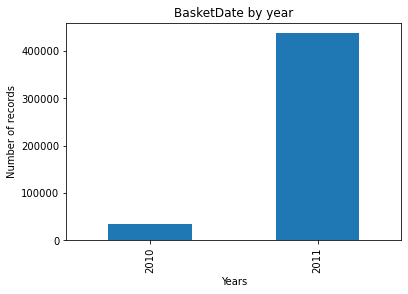

In [20]:
df['BasketDate'].groupby(df.BasketDate.dt.year).agg('count').plot(kind="bar")
plt.title("BasketDate by year")
plt.xlabel("Years")
plt.ylabel("Number of records")
plt.show()

The abundancy of records dated in 2011 with respect to those dated in 2010 is clear.

We now display the distribution of the records among the months, here expressed by a number between 1 and 12.

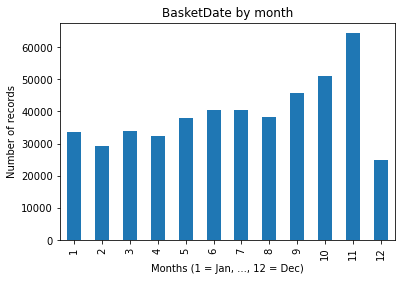

In [21]:
df['BasketDate'].groupby(df.BasketDate.dt.month).agg('count').plot(kind="bar")
plt.title("BasketDate by month")
plt.xlabel("Months (1 = Jan, ..., 12 = Dec)")
plt.ylabel("Number of records")
plt.show()

Here, a noticeable increase in the number of records, and thus transactions, happens during the last months preceding december. Said behaviour could be related to the occurance of festivities like Christmas but the low population on december itself seems opposing such theory.

We proceed by displaying the distribution of the records among the day of the week, here expressed by a nummber between 0 and 6.

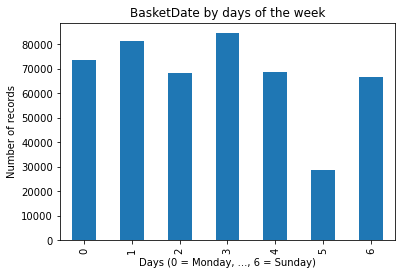

In [22]:
df['BasketDate'].groupby(df.BasketDate.dt.weekday).agg('count').plot(kind="bar")
plt.title("BasketDate by days of the week")
plt.xlabel("Days (0 = Monday, ..., 6 = Sunday)")
plt.ylabel("Number of records")
plt.show()

Here an expected behaviour could be a decreasing of records toward the end of the week, similarly to how the records from Saturday behave, but the records population dated on Sunday seems to oppose such assumption. 

We lastly display the distribution of records among the hours of the day.

Text(0, 0.5, 'Number of records')

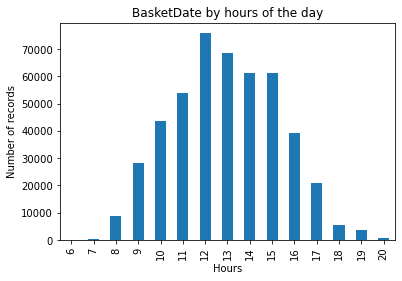

In [23]:
df['BasketDate'].groupby(df.BasketDate.dt.hour).agg('count').plot(kind="bar")
plt.title("BasketDate by hours of the day")
plt.xlabel("Hours")
plt.ylabel("Number of records")

Here we can infer the business hours of the selling store, physical or not, as starting at 6.00 AM and ending before 9.00 PM. The record rise towards the middle hours of the day is also noticeable. 

#### Sale

As mentioned above, the Sale attribute has proven to be skewed. The magnitude of such skewness is measured thanks to the pandas function **skew()**.

In [24]:
df.Sale.skew()

251.7701943919373

A positive value of such order represent a severe skewness toward the right side (along the x axis) of the distribution. 

Another metric able to describe the shape of the distribution is the Kurtosis. Such metric is responsible of measuring the distribution's peakedness.

In [25]:
df.Sale.kurt()

107198.93129197924

According to both metrics the distribution of values from the Sale attribute is supposed to be extremely tall and thin with most of the values on the right side of horizontal axis. 

Such premises are quite confirmed by the histogram displayed next.

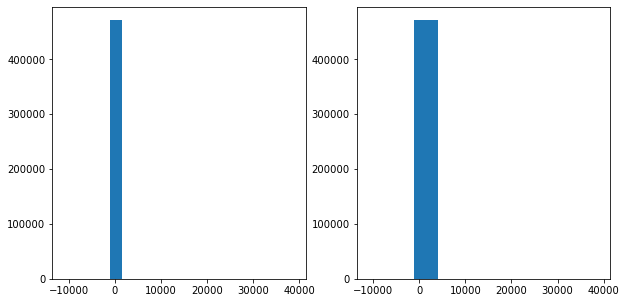

In [26]:
f, axs = plt.subplots(ncols=2, figsize=(10,5))
axs[0].hist(df.Sale, bins='sturges')
axs[1].hist(df.Sale)
plt.show() 

The presence of outliers and the severe difference in scale among the values associated with the Sale attribute doesn't permit a clear visualization of their distribution. 

We assume to be able to display more meaningful graphs after the process of outliers elimination performed within the **Assessing and Improving Data Quality** and, as such, we delay such plots at after the aforementioned activity. 

#### CustomerID

We calculate the total number of distinct values for the attribute CustomerID contained within the records from the dataset.

In [27]:
len(df.CustomerID.unique())

4373

#### CustomerCountry

Assuming *CustomerCountry* as a categorical attribute with a relatively small set of possible values, we determine the actual range of it throught the code below.

In [28]:
df.CustomerCountry.value_counts().count()

38

We now explore the distribution of records among these values.  

In [29]:
df.CustomerCountry.value_counts()

United Kingdom          426261
Germany                   9495
France                    8525
EIRE                      7824
Spain                     2533
Netherlands               2371
Belgium                   2069
Switzerland               1932
Portugal                  1495
Australia                 1259
Norway                    1086
Italy                      803
Channel Islands            758
Finland                    695
Cyprus                     622
Sweden                     462
Austria                    401
Denmark                    389
Japan                      358
Poland                     341
Unspecified                340
USA                        291
Israel                     269
Singapore                  229
Iceland                    182
Canada                     151
Greece                     146
Hong Kong                  138
Malta                      127
United Arab Emirates        68
European Community          61
RSA                         58
Lebanon 

Among them, the value "**United Kingdom**", being present within the 90% of the records in the dataset, is the most frequent one.

In [30]:
uk_percentage = df[df.CustomerCountry == "United Kingdom"].CustomerCountry.size # number of records with CustomerCountry equals to "United Kingdom"
tot_rows = df.CustomerCountry.size # number of rows within the dataframe
uk_percentage = (uk_percentage / tot_rows)*100
print(uk_percentage)

90.32675722065649


Also, 340 different records present the value "**Unspecified**" for the attribute in question. <br>(See the subsection **Handling missing values**) 

We now display the distribution of values for the CustomerCountry attribute. In order to account to the difference in scale between the number of records with value 'United Kingdom' and the other ones, we present an additional chart that does not take the former into account.

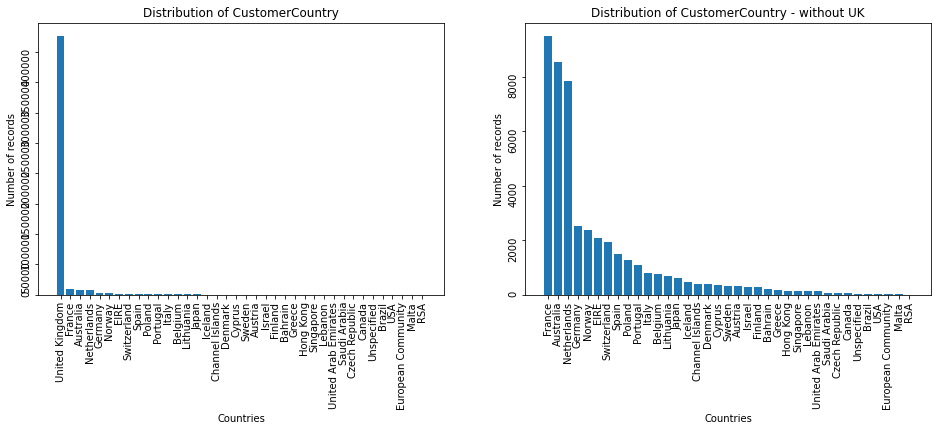

In [31]:
f, axs = plt.subplots(ncols=2, figsize=(16,5))
axs[0].bar(df.CustomerCountry.unique(),df.CustomerCountry.value_counts())
axs[0].tick_params(labelrotation=90)
axs[0].set_title("Distribution of CustomerCountry")
axs[0].set_xlabel("Countries")
axs[0].set_ylabel("Number of records")

axs[1].bar(df[df.CustomerCountry != 'United Kingdom'].CustomerCountry.unique(), df[df.CustomerCountry != 'United Kingdom'].CustomerCountry.value_counts())
axs[1].tick_params(labelrotation=90)
axs[1].set_title("Distribution of CustomerCountry - without UK")
axs[1].set_xlabel("Countries")
axs[1].set_ylabel("Number of records")

plt.show() 

#### ProdID

We calculate the total number of distinct values for the attribute ProdID contained within the records from the dataset.

In [32]:
len(df.ProdID.unique())

3953

#### ProdDescr

We calculate the total number of distinct values for the attribute ProdDescr contained within the records from the dataset.

In [33]:
len(df.ProdDescr.unique())

4098

#### Qta

Just as for the values from the Sale attribute, the ones from Qta, have displayed the potential for skewness. We again compute both the skewness and the Kurtosis of said distribution.

In [34]:
df.Qta.skew()

0.20476694612755456

In [35]:
df.Qta.kurt()

108564.3822352365

While still displaying the kurtosis of a very tall and thin distribution, the values from Qta present a, still positive but, less steep skewness.

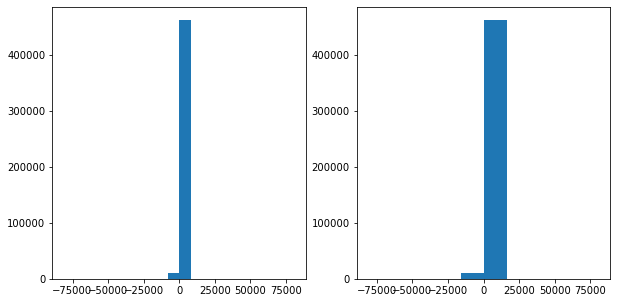

In [36]:
f, axs = plt.subplots(ncols=2, figsize=(10,5))
axs[0].hist(df.Qta, bins='sturges')
axs[1].hist(df.Qta)
plt.show() 

Again, we postpone a more clear and detailed version of the plot above at after the section **Assessing and improving Data Quality**.

## Assessing and improving Data Quality

### Handling duplicates

The pandas function **duplicated()** returns a list of boolean values where each *True* corresponds to the duplicate of a row within the dataframe. 

In [37]:
df.duplicated().any()

True

In [38]:
df.duplicated().value_counts()

False    466678
True       5232
dtype: int64

Having confirmed the presence of several duplicated rows within the dataframe, we print some of them as samples:

In [39]:
duplicates = df[df.duplicated()]
duplicates.head()

,BasketID,BasketDate,Sale,CustomerID,CustomerCountry,ProdID,ProdDescr,Qta
517,536409,2010-01-12 11:45:00,1.25,17908.00,United Kingdom,21866,UNION JACK FLAG LUGGAGE TAG,1
527,536409,2010-01-12 11:45:00,2.10,17908.00,United Kingdom,22866,HAND WARMER SCOTTY DOG DESIGN,1
537,536409,2010-01-12 11:45:00,2.95,17908.00,United Kingdom,22900,SET 2 TEA TOWELS I LOVE LONDON,1
539,536409,2010-01-12 11:45:00,4.95,17908.00,United Kingdom,22111,SCOTTIE DOG HOT WATER BOTTLE,1
555,536412,2010-01-12 11:49:00,2.95,17920.00,United Kingdom,22327,ROUND SNACK BOXES SET OF 4 SKULLS,1


We print a couple of records consisting in an "original" row and its duplicate.

In [40]:
df[(df.ProdDescr == "UNION JACK FLAG LUGGAGE TAG") & (df.CustomerID == 17908)]

,BasketID,BasketDate,Sale,CustomerID,CustomerCountry,ProdID,ProdDescr,Qta
494,536409,2010-01-12 11:45:00,1.25,17908.00,United Kingdom,21866,UNION JACK FLAG LUGGAGE TAG,1
517,536409,2010-01-12 11:45:00,1.25,17908.00,United Kingdom,21866,UNION JACK FLAG LUGGAGE TAG,1


Assuming, <u>by personal interpretation</u>, the presence of duplicate records as the result of errors during data entry, and not as the intentional addition of multiple transactions, they are deleted from the dataset.

In [41]:
df.drop_duplicates(inplace=True)
df.duplicated().any()

False

### Handling missing values

#### Missing values detection

We confirm what was established by the **info()** function regarding missing values within the dataset by making use of the pandas function **isnull()**.

In [42]:
df.isnull().any()

BasketID           False
BasketDate         False
Sale               False
CustomerID          True
CustomerCountry    False
ProdID             False
ProdDescr           True
Qta                False
dtype: bool

As mentioned above, the columns *CustomerID* and *ProdDescr* present missing values.

Other missing values could also be contained within the columns of numerical attributes like *Qta* or *Sale* (i.e. represented by a 0),
therefore, specific code needs to be written in order to check for these cases.

##### Missing values in *Sale* and *Qta*

We search for values equal to zero within both of the attributes.

In [43]:
df[df.Qta == 0].Qta.count() #Zero values in Qta

0

In [44]:
df[df.Sale == 0].Sale.count() #Zero values in Sale

1278

The sales column has several records with values equal to zero but, given the transactional
nature of the dataset under examination, we believe that the aforementioned
zero values do retain a useful significance for the purposes of our analysis.

Therefore, these attributes are not going to be involved in the process of replacing
missing values which is now focused only on the categorical attributes of the dataset.

##### Missing values in *CustomerCountry*

We compute a list of all the different values associated with the *CustomerCountry* attribute.

In [45]:
df.CustomerCountry.value_counts()

United Kingdom          421106
Germany                   9480
France                    8509
EIRE                      7814
Spain                     2528
Netherlands               2371
Belgium                   2069
Switzerland               1931
Portugal                  1486
Australia                 1258
Norway                    1086
Italy                      803
Channel Islands            757
Finland                    695
Cyprus                     611
Sweden                     461
Austria                    401
Denmark                    389
Japan                      358
Poland                     341
Unspecified                337
USA                        291
Israel                     266
Singapore                  229
Iceland                    182
Canada                     151
Greece                     146
Hong Kong                  137
Malta                      127
United Arab Emirates        68
European Community          61
RSA                         58
Lebanon 

The list above presents an "**Unspecified**" value for *CustomerCountry* associated with 340 different records. 
Given the inherent ambiguity of the value we consider it a strong candidate for a replacement with values with a stronger statistical significance.

Before committing to this decision, however, we check for the values within the *CustomerID* column of the records that present an "Unspecified" *CustomerCountry*.
Other transactions of the same customers, represented here by other records with the same value for *CustomerID*, may display a different value of *CustomerCountry* suitable to replace the others.

We compute a list of all the values for *CustomerID* associated with records with an "Unspecified" *CustomerCountry*.

In [46]:
unspecified_ids = df[df.CustomerCountry == 'Unspecified'].CustomerID.value_counts()
unspecified_ids.keys()

Float64Index([12743.0, 16320.0, 14265.0, 12363.0], dtype='float64')

We now check for every value of *CustomerCountry* associated with said values of *CustomerID*.

In [47]:
df.loc[df.CustomerID.isin(unspecified_ids.keys())].CustomerCountry.value_counts()

Unspecified    241
Name: CustomerCountry, dtype: int64

Only 241 records result associated with the aforementioned values of *CustomerID*. 

In order to ascertain the state of the 96 unaccounted rows, we now count the number of records with an "Unspecified" *CustomerCountry* and a NaN *CustomerID*.

In [48]:
nan_count = df[df.CustomerCountry == "Unspecified"].isna().CustomerID.value_counts()
nan_count

False    241
True      96
Name: CustomerID, dtype: int64

We have confermed that none of the records we have referred to are associated with a value for *CustomerCountry* other than "Unspecified".
This set of records therefore acts as an autonomous group.

While it is still possible to replace the values in question with the most frequent value of this attribute (in this case United Kingdom), we believe it is more interesting to wait for the results of the clustering process in view of a hypothetical grouping with records associated with another particular country.

#### Missing values replacement

##### Replacing the missing values from CustomerID

The CustomerID column presents several records containing missing values.

In [49]:
df.CustomerID.isnull().sum()

65073

We decide to replace each missing value depending on the value for CustomerCountry contained within its record. We select the most frequent IDs in a given *CustomerCountry*, basically computing the mode over a subset of the *CustomerID* column and use those values as substitutes for the missing ones.

These are the most frequent CustomerID for each *CustomerCountry*:

In [50]:
country_mode = df.groupby(['CustomerCountry']).agg(lambda x:x.mode()).CustomerID
country_mode

CustomerCountry
Australia              12415.00
Austria                12360.00
Bahrain                12355.00
Belgium                12362.00
Brazil                 12769.00
Canada                 17444.00
Channel Islands        14936.00
Cyprus                 12359.00
Czech Republic         12781.00
Denmark                12406.00
EIRE                   14911.00
European Community     15108.00
Finland                12428.00
France                 12681.00
Germany                12471.00
Greece                 12717.00
Hong Kong                    []
Iceland                12347.00
Israel                 12688.00
Italy                  12584.00
Japan                  12753.00
Lebanon                12764.00
Lithuania              15332.00
Malta                  17828.00
Netherlands            14646.00
Norway                 12433.00
Poland                 12779.00
Portugal               12757.00
RSA                    12446.00
Saudi Arabia           12565.00
Singapore              1

No CustomerID is associated with any of the records with *CustomerCountry* equals to "Hong Kong". For the sake of replacing these empty values we craft a custom CustomerID and add it to the aforementioned list. 

Here we check to see if the custom ID is already present within the dataset.

In [51]:
df[df.CustomerID == "18288.0"].CustomerID.count() #We check to see if the custom ID is already present within the dataset 

0

Being it currently absent from the dataset we confirm our choice as custom CustomerID for the records from Hong Kong.

In [52]:
country_mode["Hong Kong"] = "18288.0"

Now we substitute each missing value with the corresponding element from the list.

In [53]:
#We replace the missing values from CustomerID with the elements from country_mode
df['CustomerID'] = df.apply(
    lambda row: country_mode[row['CustomerCountry']] if pd.isnull(row['CustomerID']) else row['CustomerID'],
    axis=1
)

After the process the number of missing values is down to zero.

In [54]:
df.CustomerID.isnull().sum()

0

### Handling outliers

#### Handling the records related to refund activities

We already described the interesting characteristic of such couples of records within the section dedicated to the statistics of the dataset. 

We now implement the balancing procedure previously mentioned. 

In [55]:
neg_purchases = df[(df.BasketID.str.contains('C')) & (df.Qta < 0)]
for c_purchase in neg_purchases.iterrows():
    c_index = c_purchase[0]
    c_customerID = c_purchase[1].CustomerID
    c_prodID = c_purchase[1].ProdID
    c_Qta = c_purchase[1].Qta
    pos_purchases = df[(df.CustomerID == c_customerID ) & (df.ProdID == c_prodID ) & (df.Qta > 0)]
    for pos_purchase in pos_purchases.iterrows():
        if  pos_purchase[1].Qta == abs(c_Qta):
            df.drop([c_index, pos_purchase[0]], inplace=True)
            break
        elif pos_purchase[1].Qta > abs(c_Qta):
            df.loc[pos_purchase[0]].Qta = pos_purchase[1].Qta - abs(c_Qta)
            df.drop([c_index], inplace=True)
            break
        else:
            c_Qta = c_Qta + pos_purchase[1].Qta
            df.drop([pos_purchase[0]], inplace=True)
        df.loc[c_index].Qta = c_Qta

C:\Users\markp\anaconda3\lib\site-packages\pandas\core\generic.py:5303: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


We scan the dataset for the remaining records with negative values for Qta.

In [56]:
df[(df.BasketID.str.contains('C')) & (df.Qta < 0)].BasketID.count()

1075

#### Outliers Detection

We have already mentioned how both the *Sale* and *Qta* attributes contain very high values that could be easily classified as outliers, here we provide a deeper analysis of said phenomenon.

These are the boxplots for the two attributes computed by the pandas function **boxplot()**:

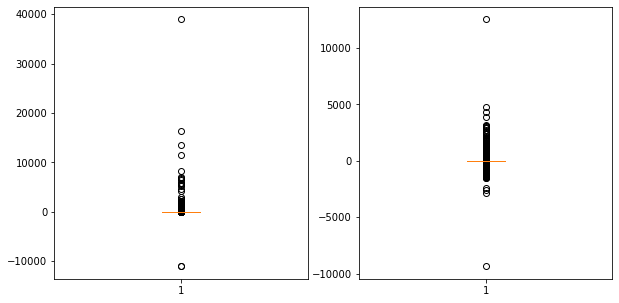

In [57]:
f, axs = plt.subplots(ncols=2, figsize=(10,5))
axs[0].boxplot(df.Sale)
axs[1].boxplot(df.Qta)
plt.show()

Indeed both plots seem to be deeply affected by outliers. 
We proceed by computing the **interquantile range** (**IQR**) and by limiting the plot to the points within it.

We start by defining a function for computing the IQR:

In [58]:
def iqr_values(s): 
    q1 = s.quantile(q = 0.25)
    q3 = s.quantile(q = 0.75)
    iqr = q3 - q1
    iqr_left = q1 - 1.5*iqr
    iqr_right = q3 + 1.5*iqr
    return iqr_left, iqr_right

Now we apply said function to *Sale* and plot the new boxplot. 

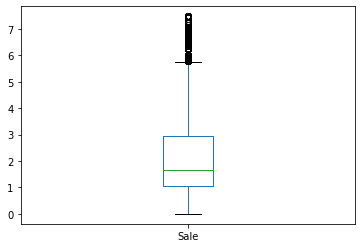

In [59]:
left_sale, right_sale = iqr_values(df.Sale)
df[(df.Sale > left_sale) & (df.Sale < right_sale)].Sale.plot.box()

We do the same the *Qta* attribute.

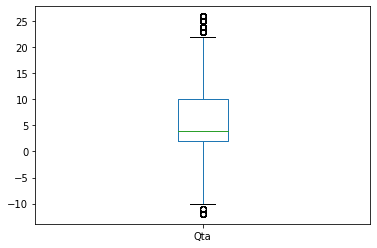

In [60]:
left_qta, right_qta = iqr_values(df.Qta)
df[(df.Qta > left_qta) & (df.Qta < right_qta)].Qta.plot.box()

We select the records containing outliers for the *Sale* and *Qta* attributes.

In [61]:
df_outliers = df[(df.Sale < left_sale) | (df.Sale > right_sale) | (df.Qta < left_qta) | (df.Qta > right_qta)]
df_outliers

,BasketID,BasketDate,Sale,CustomerID,CustomerCountry,ProdID,ProdDescr,Qta
5,536365,2010-01-12 08:26:00,7.65,17850.00,United Kingdom,22752,SET 7 BABUSHKA NESTING BOXES,2
13,536367,2010-01-12 08:34:00,1.69,13047.00,United Kingdom,84879,ASSORTED COLOUR BIRD ORNAMENT,32
20,536367,2010-01-12 08:34:00,9.95,13047.00,United Kingdom,22622,BOX OF VINTAGE ALPHABET BLOCKS,2
23,536367,2010-01-12 08:34:00,7.95,13047.00,United Kingdom,21777,RECIPE BOX WITH METAL HEART,4
24,536367,2010-01-12 08:34:00,7.95,13047.00,United Kingdom,48187,DOORMAT NEW ENGLAND,4
...,...,...,...,...,...,...,...,...
541866,581583,2011-09-12 12:23:00,1.85,13777.00,United Kingdom,85038,6 CHOCOLATE LOVE HEART T-LIGHTS,36
541867,581584,2011-09-12 12:25:00,0.72,13777.00,United Kingdom,20832,RED FLOCK LOVE HEART PHOTO FRAME,72
541868,581584,2011-09-12 12:25:00,1.85,13777.00,United Kingdom,85038,6 CHOCOLATE LOVE HEART T-LIGHTS,48
541892,581586,2011-09-12 12:49:00,8.95,13113.00,United Kingdom,21217,RED RETROSPOT ROUND CAKE TINS,24


We delete said records from the dataframe.

In [62]:
df.drop(df_outliers.index, inplace=True)

### Extra: New Distributions of Sale and Qta

We now check again for skewness and Kurtonis in both the populations of Sale and Qta.

In [63]:
print('Sale:')
print('Skewness: ' + str(df.Sale.skew()))
print('Kurtonis: ' + str(df.Sale.kurt()))

Sale:
Skewness: 1.0085658509928024
Kurtonis: 0.3906166985773676


The Sale attribute still presents a positive skewness which is clearly less intense than before. Its Kurtonis however is also greatly reduce so, its population should be more flat and wide than before.

In [64]:
print('Qta:')
print('Skewness: ' + str(df.Qta.skew()))
print('Kurtonis: ' + str(df.Qta.kurt()))

Qta:
Skewness: 1.3226338692885695
Kurtonis: 1.0231010090836965


The skewness and Kurtonis values for the Qta attribute still suggest a tall distribusion skewed toward the right side of the axis but both behavious should be far less intense than before.

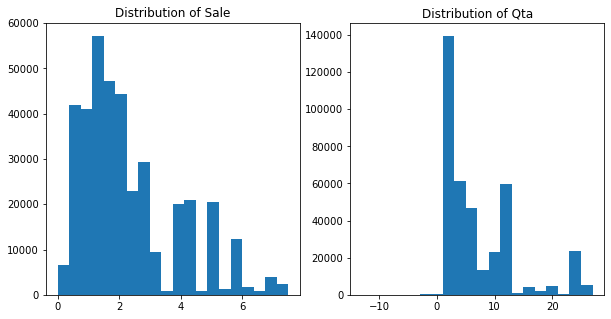

In [65]:
f, axs = plt.subplots(ncols=2, figsize=(10,5))
axs[0].hist(df.Sale, bins='sturges')
axs[0].set_title('Distribution of Sale')
axs[1].hist(df.Qta, bins='sturges')
axs[1].set_title('Distribution of Qta')
plt.show() 

Such premises are confermed by the populatons dispayed by the histograms above.

## Correlation

We use the pandas **corr()** function to compute the **Pearson correlation coefficient** for the numerical attributes of the dataset: *Sale* and *Qta*.

In [66]:
df.corr()

,Sale,Qta
Sale,1.00,-0.35
Qta,-0.35,1.00


Despite counting on results similar to those just computed, we compare the pearson correlation coefficient, calculated by default by the **corr()** function, with the **Kendall** and **Spearman** correlations.

In [67]:
df.corr(method='kendall')

,Sale,Qta
Sale,1.00,-0.25
Qta,-0.25,1.00


In [68]:
df.corr(method='spearman')

,Sale,Qta
Sale,1.00,-0.33
Qta,-0.33,1.00


Ultimately, according to the values above, the two attributes seems to be slightly correlated. 
<br>Moreover, the negative sign of the coefficient highlights how the attributes tend to move in opposite direction.

### Scatter Plots

We proceed by visualizing the correlation through the use of scatterplots. 

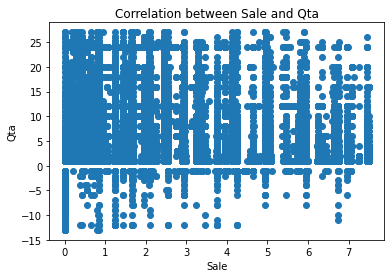

In [69]:
plt.scatter(df['Sale'], df['Qta'])
plt.xlabel('Sale')
plt.ylabel('Qta')
plt.title('Correlation between Sale and Qta')
plt.show()

The same scatter plot, enhanced with information from the categorical attributes of the dataset will be featured within the **Data Visualization** section.

## Data Transformation

### Sale as cost for unit and Sale_per_Qta

Asssuming the values for Sale as the cost of one single unit of the product associated with ProdID, and in order to account to the total amount spent by each customer for its transactions, we compute an additional feature called Sale_per_Qta.

In [196]:
df['Sale_per_Qta'] = df.Sale.mul(df.Qta)

## Data Visualization

We include the following function in order to help with the visualization of the data. Said function will interact with the bars from a bar plot by adding their cardinality on top of each rectangle.

In [197]:
def autolabel(rects, i = None, j = None):
    if (i != None) and (j!=None): 
        """Attach a text label above each bar in *rects*, displaying its height."""
        for rect in rects:
            height = rect.get_height()
            axs[i][j].annotate('{}'.format(height),
                            xy=(rect.get_x() + rect.get_width() / 2, height),
                            xytext=(0, 3),  # 3 points vertical offset
                            textcoords="offset points",
                            ha='center', va='bottom')
    elif i != None:
        for rect in rects:
            height = rect.get_height()
            axs[i].annotate('{}'.format(height),
                            xy=(rect.get_x() + rect.get_width() / 2, height),
                            xytext=(0, 3),  # 3 points vertical offset
                            textcoords="offset points",
                            ha='center', va='bottom')
    else:
        for rect in rects:
            height = rect.get_height()
            axs.annotate('{}'.format(height),
                            xy=(rect.get_x() + rect.get_width() / 2, height),
                            xytext=(0, 3),  # 3 points vertical offset
                            textcoords="offset points",
                            ha='center', va='bottom')

        

### Periodical Plots

In order to build plots displaying the behaviour of attributes like Sale and Qta over period of times, we create an *ad hoc dataframe* by duplicating the original one and setting the BaskeDate attribute as index.

In [198]:
df2 = df.copy()
df2.index = pd.to_datetime(df['BasketDate'], format='%d/%m/%y %H:%M')

#### Dividing the observation period in months: Monthly sales and quantities

We display the behaviour of both the Sale and Qta attributes over the months within our period of observation, both as mean and total value.

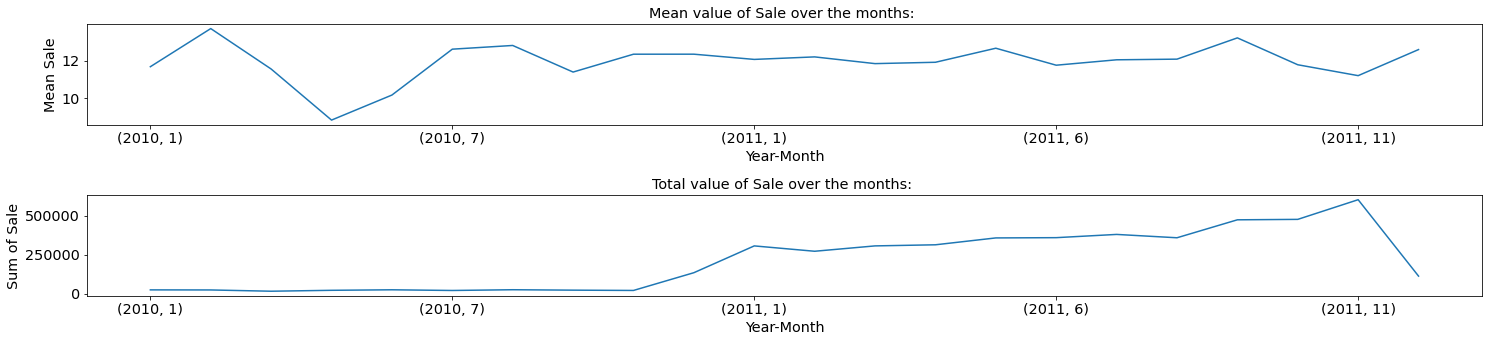

In [199]:
# Set up a grid of plots:
fig = plt.figure(figsize=(25, 5))
fig_dims = (2, 1)
fig.subplots_adjust(hspace=0.7)

# Plot mean sales 
plt.subplot2grid(fig_dims, (0, 0))
monthly_sales_mean = df2['Sale_per_Qta'].groupby([df2.index.year, df2.index.month]).mean().plot()
plt.title('Mean value of Sale over the months: ', fontsize='x-large')
plt.xlabel('Year-Month', fontsize='x-large')
plt.ylabel('Mean Sale', fontsize='x-large')
plt.tick_params(labelsize='x-large')

# Plot total sales
plt.subplot2grid(fig_dims, (1, 0))
monthly_sales_total = df2['Sale_per_Qta'].groupby([df2.index.year, df2.index.month]).sum().plot()
plt.title('Total value of Sale over the months: ', fontsize='x-large')
plt.xlabel('Year-Month', fontsize='x-large')
plt.ylabel('Sum of Sale', fontsize='x-large')
plt.tick_params(labelsize='x-large')

plt.show()

The shortage of observations from the year 2010 is highlighted by the values for the total amount spent by the customers within the first half of the graph above.


#### Dividing the observation period in weeks: Weekly sales and quantities

We display the behaviour of both the Sale and Qta attributes over the weeks within our period of observation, both as mean and total value.

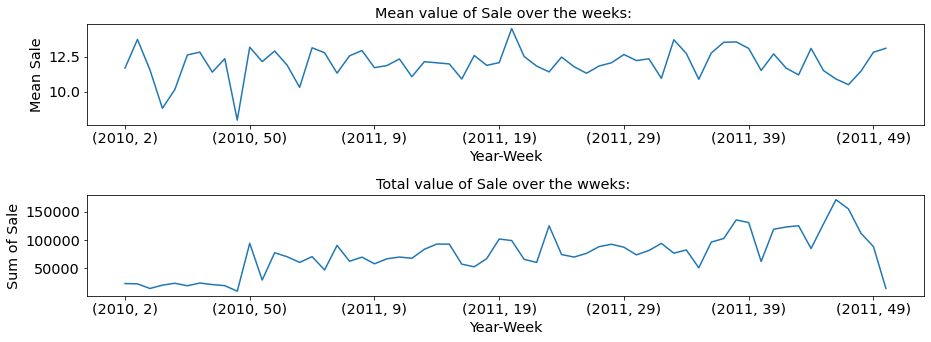

In [200]:
# Set up a grid of plots:
fig = plt.figure(figsize=(15, 5))
fig_dims = (2, 1)
fig.subplots_adjust(hspace=0.7)

# Plot mean sales 
plt.subplot2grid(fig_dims, (0, 0))
monthly_sales_mean = df2['Sale_per_Qta'].groupby([df2.index.year, df2.index.week]).mean().plot()
plt.title('Mean value of Sale over the weeks: ', fontsize='x-large')
plt.xlabel('Year-Week', fontsize='x-large')
plt.ylabel('Mean Sale', fontsize='x-large')
plt.tick_params(labelsize='x-large')

# Plot total sales
plt.subplot2grid(fig_dims, (1, 0))
monthly_sales_total = df2['Sale_per_Qta'].groupby([df2.index.year, df2.index.week]).sum().plot()
plt.title('Total value of Sale over the wweks: ', fontsize='x-large')
plt.xlabel('Year-Week', fontsize='x-large')
plt.ylabel('Sum of Sale', fontsize='x-large')
plt.tick_params(labelsize='x-large')

plt.show()

#### Observing the behaviour of Sale and Qta over the month

We display the total and mean amount of both the Sale and Qta attributes over the course of the month.

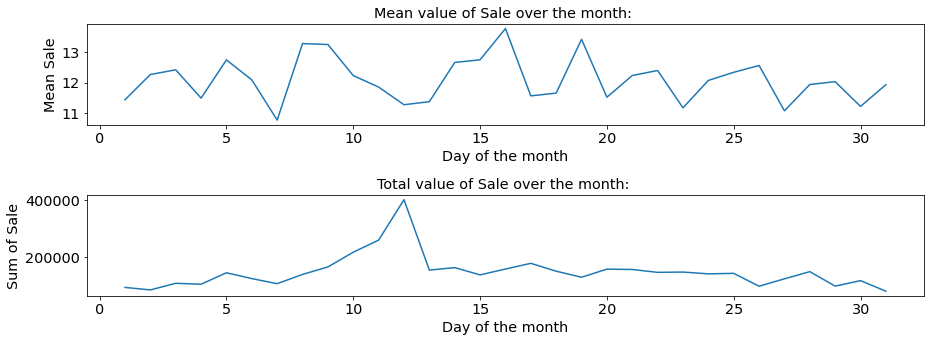

In [201]:
# Set up a grid of plots:
fig = plt.figure(figsize=(15, 5))
fig_dims = (2, 1)
fig.subplots_adjust(hspace=0.7)

# Plot mean sales 
plt.subplot2grid(fig_dims, (0, 0))
monthly_sales_mean = df2['Sale_per_Qta'].groupby(df2.index.day).mean().plot()
plt.title('Mean value of Sale over the month: ', fontsize='x-large')
plt.xlabel('Day of the month', fontsize='x-large')
plt.ylabel('Mean Sale', fontsize='x-large')
plt.tick_params(labelsize='x-large')

# Plot total sales
plt.subplot2grid(fig_dims, (1, 0))
monthly_sales_total = df2['Sale_per_Qta'].groupby(df2.index.day).sum().plot()
plt.title('Total value of Sale over the month: ', fontsize='x-large')
plt.xlabel('Day of the month', fontsize='x-large')
plt.ylabel('Sum of Sale', fontsize='x-large')
plt.tick_params(labelsize='x-large')

plt.show()

#### Observing the behaviour of Sale and Qta over the week

We display the total and mean amount of both the Sale and Qta attributes over the course of the week.

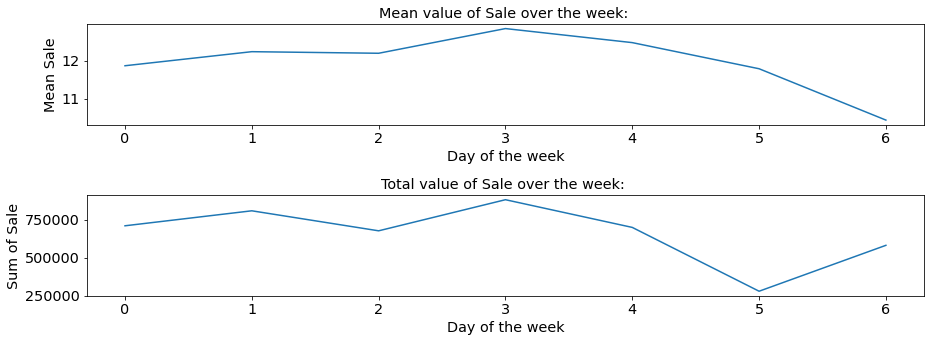

In [202]:
# Set up a grid of plots:
fig = plt.figure(figsize=(15, 5))
fig_dims = (2, 1)
fig.subplots_adjust(hspace=0.7)

# Plot mean sales 
plt.subplot2grid(fig_dims, (0, 0))
monthly_sales_mean = df2['Sale_per_Qta'].groupby(df2.index.weekday).mean().plot()
plt.title('Mean value of Sale over the week: ', fontsize='x-large')
plt.xlabel('Day of the week', fontsize='x-large')
plt.ylabel('Mean Sale', fontsize='x-large')
plt.tick_params(labelsize='x-large')

# Plot total sales
plt.subplot2grid(fig_dims, (1, 0))
monthly_sales_total = df2['Sale_per_Qta'].groupby(df2.index.weekday).sum().plot()
plt.title('Total value of Sale over the week: ', fontsize='x-large')
plt.xlabel('Day of the week', fontsize='x-large')
plt.ylabel('Sum of Sale', fontsize='x-large')
plt.tick_params(labelsize='x-large')

plt.show()

Both graphs suggest an increase in both the number of purchases and their cost around Thursday. 
The low total amount spent by the customers around Saturday instead suggest an overall decrease in the number of purchases.

#### Observing the behaviour of Sale and Qta over the day

We display the total and mean amount of both the Sale and Qta attributes over the course of the day.

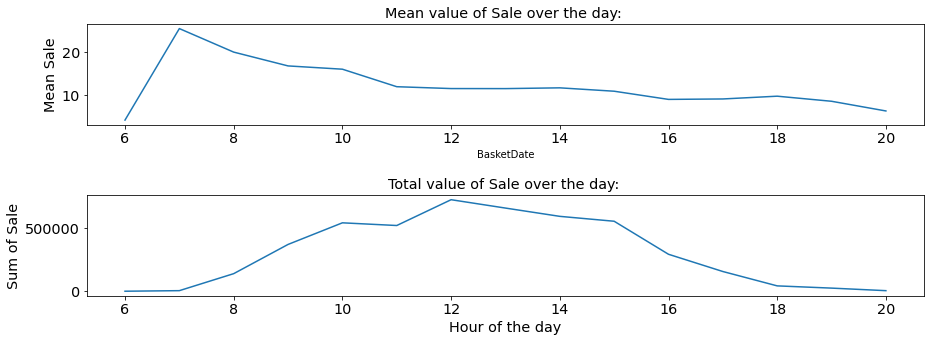

In [203]:
# Set up a grid of plots:
fig = plt.figure(figsize=(15, 5))
fig_dims = (2, 1)
fig.subplots_adjust(hspace=0.7)

# Plot mean sales 
plt.subplot2grid(fig_dims, (0, 0))
monthly_sales_mean = df2['Sale_per_Qta'].groupby(df2.index.hour).mean().plot()
plt.title('Mean value of Sale over the day: ', fontsize='x-large')
plt.ylabel('Mean Sale', fontsize='x-large')
plt.tick_params(labelsize='x-large')

# Plot total sales
plt.subplot2grid(fig_dims, (1, 0))
monthly_sales_total = df2['Sale_per_Qta'].groupby(df2.index.hour).sum().plot()
plt.title('Total value of Sale over the day: ', fontsize='x-large')
plt.xlabel('Hour of the day', fontsize='x-large')
plt.ylabel('Sum of Sale', fontsize='x-large')
plt.tick_params(labelsize='x-large')

plt.show()

From the high mean and low total values during the morning we can infer the presence of few, but relatively costly, purchases during the store's first hours of activity.

Also, the medium mean and hight total values around the central hours of the day suggest the presence of several medium-small purchases. 

### Display the interaction of Sale and Qta with CustomerCountry

#### Number of Customer per CustomerCountry

Including the population with CustomerCountry equals to'United Kingdom' within the same plot of the remaining population would harm the scale among values and thus decrease the readability of the graphs. 

We therefore split the visualization of statistics between the UK population and the one with different values of CustomerCountry.

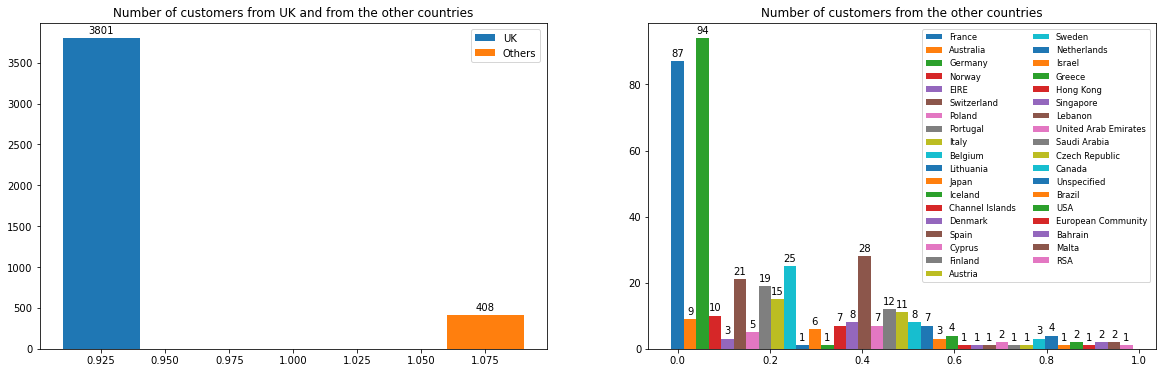

In [204]:
uk_cust = [len(df[df.CustomerCountry == 'United Kingdom'].CustomerID.unique())]
others_cust = [len(df[df.CustomerCountry != 'United Kingdom'].CustomerID.unique())]

width = 0.15

f, axs = plt.subplots(nrows=1, ncols=2, figsize=(20,6))

autolabel(axs[0].bar(1 - width/2, uk_cust, width/5, label='UK'), 0)
autolabel(axs[0].bar(1 + width/2, others_cust, width/5, label='Others'), 0)
axs[0].legend(bbox_to_anchor=(0.85, 0.98), loc='upper left', borderaxespad=0.)
axs[0].set_title('Number of customers from UK and from the other countries')

other_countries = df[df.CustomerCountry != 'United Kingdom'].CustomerCountry.unique()
for i in range(len(other_countries)):
    point = (1/len(other_countries) * i)
    autolabel(axs[1].bar(point, len(df[df.CustomerCountry == other_countries[i]].CustomerID.unique()), (1/len(other_countries)), label=other_countries[i]), 1)
axs[1].legend(bbox_to_anchor=(0.54, 0.98), loc='upper left', borderaxespad=0., ncol=2, fontsize='small')
axs[1].set_title('Number of customers from the other countries')

plt.show()

#### Total Sale_per_Qta per CustomerCountry

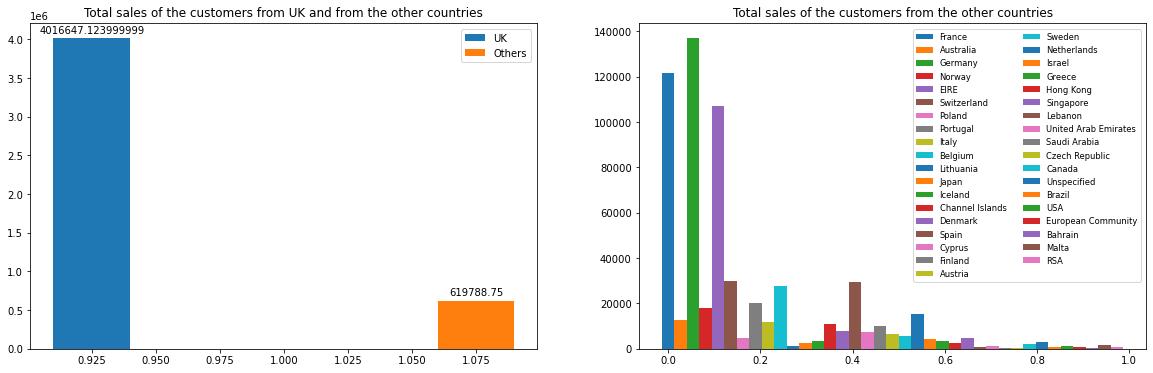

In [205]:
uk_cust = [df[df.CustomerCountry == 'United Kingdom'].Sale_per_Qta.sum()]
others_cust = [df[df.CustomerCountry != 'United Kingdom'].Sale_per_Qta.sum()]

width = 0.15

f, axs = plt.subplots(nrows=1, ncols=2, figsize=(20,6))

autolabel(axs[0].bar(1 - width/2, uk_cust, width/5, label='UK'), 0)
autolabel(axs[0].bar(1 + width/2, others_cust, width/5, label='Others'), 0)
axs[0].legend(bbox_to_anchor=(0.85, 0.98), loc='upper left', borderaxespad=0.)
axs[0].set_title('Total sales of the customers from UK and from the other countries')

other_countries = df[df.CustomerCountry != 'United Kingdom'].CustomerCountry.unique()
for i in range(len(other_countries)):
    point = (1/len(other_countries) * i)
    axs[1].bar(point, df[df.CustomerCountry == other_countries[i]].Sale_per_Qta.sum(), (1/len(other_countries)), label=other_countries[i])
axs[1].legend(bbox_to_anchor=(0.54, 0.98), loc='upper left', borderaxespad=0., ncol=2, fontsize='small')
axs[1].set_title('Total sales of the customers from the other countries')

plt.show()

## Building a New Dataset: *Customers*

We now design and compute new features useful for describing the customer profile and its purchasing behavior.

### *Customers*: Numerical Attributes

We create a new dataframe responsible of containg the numerical attributes of the new dataset.

In [206]:
CustomerIDs = df['CustomerID'].unique()
cs = pd.DataFrame(CustomerIDs)
cs.set_index(0, inplace=True)
cs.index.names = ['CustomerID']

We create a copy of the aforementioned dataframe in order to later employ an approach similar to the one shortly following but aimed to categorical attributes derived from the original customers.

In [207]:
cs_cat = cs.copy()

#### I: total number of purchased items

In [208]:
# total number of items purchased by a customer
I = df['Qta'].groupby(df['CustomerID']).sum()
# create dataframe
I = pd.DataFrame(I)
# add column to the new dataset
cs['I'] = I.Qta

#### Iu: number of distinct purchased items 

In [209]:
# number of distinct items bought by a customer
Iu = df['ProdID'].groupby(df['CustomerID']).unique().apply(len)
# create dataframe
Iu = pd.DataFrame(Iu)
# add column to the new dataset
cs['Iu'] = Iu.ProdID

#### Imax: maximum number of items purchased within a single shopping session

In [210]:
# maximum number of items purchased by a customer during a shopping session
Imax = df.groupby(by=[ 'CustomerID', 'BasketID']).Qta.sum().max(level='CustomerID')
# create dataframe
Imax = pd.DataFrame(Imax)
# add column to the new dataset
cs['Imax'] = Imax.Qta

#### E: Shannon's Entropy on the products purchased by the customer (ProdID)

In [211]:
# Shannon entropy on the purchasing behaviour of the customer
def estimate_shannon_entropy(values):
    m = len(values)
    IDs = collections.Counter([value for value in values])
    shannon_entropy_value = 0
    for ID in IDs:
        # number of residues
        n_i = IDs[ID]
        # n_i (# residues type i) / M (# residues in column)
        p_i = n_i / float(m)
        entropy_i = p_i * (math.log(p_i, 2))
        shannon_entropy_value += entropy_i
    if shannon_entropy_value == 0:
        return 0

    return shannon_entropy_value * -1

In [212]:
E = df.groupby(by=[ 'CustomerID']).ProdID.apply(estimate_shannon_entropy)
# create dataframe
E = pd.DataFrame(E)
# add column to the new dataset
cs['E'] = E

#### Eb: Shannon's Entropy on the frequency and extent of the customer's shopping sessions (BasketID)

In [213]:
Eb = df.groupby(by=[ 'CustomerID']).BasketID.apply(estimate_shannon_entropy)
# create dataframe
Eb = pd.DataFrame(Eb)
# add column to the new dataset
cs['Eb'] = Eb

#### Ew: Shannon's Entropy on the weekday of the customer's purchases (BasketDate.dt.day_name)

In [214]:
Ew = df.copy()
Ew['BasketDate'] = Ew.BasketDate.dt.day_name(locale = 'English')
Ew = Ew.groupby(by=[ 'CustomerID']).BasketDate.apply(estimate_shannon_entropy)
# create dataframe
Ew = pd.DataFrame(Ew)
# add column to the new dataset
cs['Ew'] = Ew

#### Em: Shannon's Entropy on the month of the customer's purchases (BasketDate.dt.month_name)

In [215]:
Em = df.copy()
Em['BasketDate'] = Em.BasketDate.dt.month_name(locale = 'English')
Em = Em.groupby(by=[ 'CustomerID']).BasketDate.apply(estimate_shannon_entropy)
# create dataframe
Em = pd.DataFrame(Em)
# add column to the new dataset
cs['Em'] = Em

#### Stot: total amount spent

In [216]:
# total spent by a customer
Stot = df.groupby(df['CustomerID']).Sale_per_Qta.sum()
# create dataframe
Stot = pd.DataFrame(Stot)
# add column to the new dataset
cs['Stot'] = Stot

#### Smax: Maximum amout spent within a single shopping session

In [217]:
# maximum amount spent by a customer during a shopping session
Smax = df.groupby(by=[ 'CustomerID', 'BasketID']).Sale_per_Qta.sum().max(level='CustomerID')
# create dataframe
Smax = pd.DataFrame(Smax)
# add column to the new dataset
cs['Smax'] = Smax

#### NSess: number of shopping sessions 

In [218]:
# number of shopping sessions
NSess = df['BasketID'].groupby(df['CustomerID']).count()
# create dataframe
NSess = pd.DataFrame(NSess)
# add column to the new dataset
cs['NSess'] = NSess

#### Summary on the numerical attributes

In [219]:
cs

,I,Iu,Imax,E,Eb,Ew,Em,Stot,Smax,NSess
CustomerID,,,,,,,,,,
17850.00,1643,22,134,4.25,4.63,0.92,0.92,4394.74,394.16,271
13047.00,1296,89,301,6.25,2.88,1.96,2.22,2614.81,449.70,146
12583.00,3031,103,362,6.36,3.82,2.58,3.00,5267.89,737.66,203
14688.00,2312,133,251,6.72,4.05,2.12,3.02,3394.39,402.50,264
17809.00,305,27,204,4.75,1.58,1.39,1.58,729.45,560.40,27
...,...,...,...,...,...,...,...,...,...,...
13436.00,69,8,69,3.00,0.00,0.00,0.00,113.54,113.54,8
15520.00,194,17,194,4.09,0.00,0.00,0.00,320.70,320.70,17
13298.00,24,1,24,0.00,0.00,0.00,0.00,90.00,90.00,1


### *Customers*: Categorical Attributes

In anticipation of applying a clustering process to the customer dataset, we prepare a separate dataset containing categorical characteristics for use during post-processing analysis.

#### Country: Country associated with the customer

In [220]:
C = df.groupby(by=[ 'CustomerID']).CustomerCountry.unique()
# create dataframe
C = pd.DataFrame(C.apply(lambda x: x[0]))
# add column to the new dataset
cs_cat['Country'] = C

#### Weekly Behaviour (Monday, ..., Sunday): number of distinct products purchased for every day of the week

In [221]:
W = df[['BasketID', 'CustomerID', 'BasketDate']]
W['BasketDate'] = W['BasketDate'].dt.day_name(locale = 'English')
weekdays_counts = W.groupby(['CustomerID', 'BasketID']).BasketDate.value_counts()
cs_weekdays = {}
for row in weekdays_counts.iteritems():
    if row[0][0] in cs_weekdays:
        if row[0][2] in cs_weekdays[row[0][0]]:
            cs_weekdays[row[0][0]][row[0][2]] = cs_weekdays[row[0][0]][row[0][2]] + row[1]
        else:
            cs_weekdays[row[0][0]][row[0][2]] = row[1]
    else:
        cs_weekdays[row[0][0]] = {row[0][2]: row[1]}
W = pd.DataFrame.from_dict(cs_weekdays, orient='index').fillna(0)
cs_cat = cs_cat.join(W)

<ipython-input-221-a1f054938552>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  W['BasketDate'] = W['BasketDate'].dt.day_name(locale = 'English')


#### Weekly Behaviour (Week): most frequent day of the week for the customer's shopping sessions 

In [222]:
W = df[['CustomerID', 'BasketDate']]
W['BasketDate'] = W['BasketDate'].dt.day_name(locale = 'English') 
W = W.groupby(by=[ 'CustomerID']).agg(lambda x: x.mode())

#Create Dataframe
W = pd.DataFrame(W.BasketDate.apply(lambda x: x[0] if isinstance(x, np.ndarray) else x))
# add column to the new dataset
cs_cat['Weekday'] = W

<ipython-input-222-6332c366ba58>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  W['BasketDate'] = W['BasketDate'].dt.day_name(locale = 'English')


#### Monthly Behaviour (January, ..., December): number of distinct products purchased for every month

In [223]:
M = df[['BasketID', 'CustomerID', 'BasketDate']]
M['BasketDate'] = M['BasketDate'].dt.month_name(locale = 'English')
months_counts = M.groupby(['CustomerID', 'BasketID']).BasketDate.value_counts()
cs_months = {}
for row in months_counts.iteritems():
    if row[0][0] in cs_months:
        if row[0][2] in cs_months[row[0][0]]:
            cs_months[row[0][0]][row[0][2]] = cs_months[row[0][0]][row[0][2]] + row[1]
        else:
            cs_months[row[0][0]][row[0][2]] = row[1]
    else:
        cs_months[row[0][0]] = {row[0][2]: row[1]}
M = pd.DataFrame.from_dict(cs_months, orient='index').fillna(0)
cs_cat = cs_cat.join(M)

<ipython-input-223-bbb2968c8061>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  M['BasketDate'] = M['BasketDate'].dt.month_name(locale = 'English')


#### Monthly Behaviour (Month): monst frequent month for the customer's shopping sessions

In [224]:
M = df[['CustomerID', 'BasketDate']]
M['BasketDate'] = M['BasketDate'].dt.month_name(locale = 'English') 
M = M.groupby(by=[ 'CustomerID']).agg(lambda x: x.mode())

#Create Dataframe
M = pd.DataFrame(M.BasketDate.apply(lambda x: x[0] if isinstance(x, np.ndarray) else x))
# add column to the new dataset
cs_cat['Month'] = M

<ipython-input-224-96620ccc5aff>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  M['BasketDate'] = M['BasketDate'].dt.month_name(locale = 'English')


#### Summary on the categorical attributes

We re-arrange the order of the column within the dataset for the categorical features.

In [225]:
cs_cat = cs_cat[['Country', 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday', 
                'January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December', 'Weekday', 'Month']]

We display the current arrangement of said dataset as a sample.

In [226]:
cs_cat.head()

,Country,Monday,Tuesday,Wednesday,Thursday,Friday,Saturday,Sunday,January,February,...,May,June,July,August,September,October,November,December,Weekday,Month
CustomerID,,,,,,,,,,,,,,,,,,,,,
17850.00,United Kingdom,0.00,72.00,0.00,0.00,196.00,0.00,3.00,72.00,196.00,...,0.00,0.00,0.00,0.00,0.00,3.00,0.00,0.00,Friday,February
13047.00,United Kingdom,0.00,30.00,41.00,0.00,49.00,0.00,26.00,13.00,0.00,...,0.00,26.00,0.00,0.00,0.00,26.00,0.00,0.00,Friday,March
12583.00,France,31.00,52.00,20.00,45.00,31.00,4.00,20.00,17.00,0.00,...,17.00,10.00,33.00,42.00,33.00,9.00,28.00,14.00,Tuesday,August
14688.00,United Kingdom,87.00,87.00,40.00,5.00,7.00,38.00,0.00,56.00,72.00,...,12.00,13.00,5.00,16.00,7.00,31.00,0.00,11.00,Monday,February
17809.00,United Kingdom,0.00,13.00,3.00,0.00,11.00,0.00,0.00,1.00,12.00,...,0.00,0.00,0.00,0.00,0.00,0.00,3.00,0.00,Tuesday,February


## Data Statistics of the Customers Dataset

We again use the pandas function **describe()** in order to obtain statistical information regarding the new dataset.

In [227]:
cs.describe()

,I,Iu,Imax,E,Eb,Ew,Em,Stot,Smax,NSess
count,4209.00,4209.00,4209.00,4209.00,4209.00,4209.00,4209.00,4209.00,4209.00,4209.00
mean,626.76,55.46,217.53,4.79,1.18,0.84,0.99,1101.55,352.36,91.59
std,2687.49,87.62,202.36,1.71,1.18,0.81,0.97,6485.60,333.13,943.87
min,-128.00,1.00,-128.00,0.00,0.00,0.00,0.00,-240.64,-240.64,1.00
25%,111.00,13.00,88.00,3.70,0.00,0.00,0.00,201.48,153.86,14.00
50%,273.00,31.00,168.00,4.91,0.99,0.90,0.95,462.21,276.26,35.00
75%,680.00,69.00,285.00,6.03,1.96,1.51,1.74,1115.55,430.98,86.00
max,155711.00,3083.00,2434.00,10.69,9.47,2.77,3.55,397990.38,4721.74,60342.00


Despite the previous efforts in balancing the customers refunds, the table above highlights the presence of negative values for the attributes I, Imax, Stot and Smax. 

We now apply once again the pandas function **skew()** and **kurt()** in order to obtain additional informations regarding the shape of the attributes distributions.

In [228]:
cs.skew()

I       47.52
Iu      13.64
Imax     3.24
E       -0.46
Eb       0.92
Ew       0.41
Em       0.54
Stot    55.16
Smax     4.09
NSess   61.92
dtype: float64

Attributes like I, Iu, Stot and Nsess presents an intense positive skewness.

In [229]:
cs.kurt()

I       2665.72
Iu       384.69
Imax      20.40
E          0.15
Eb         0.83
Ew        -1.12
Em        -0.84
Stot    3342.08
Smax      32.26
NSess   3948.65
dtype: float64

Also, most of the attributes from Customers seems to have a value of Kurtosis greatly over 3. This classify them as leptokurtic and suggests an heavy presence of outliers. 
In order to deal with said outliers we again dedicate a section to improving the data quality of the dataset. The distributions of the attributes from Customers will be displayed after the aforemenioned process.  

## Improving the Data Quality of the *Customers* Dataset

### Detecting the outliers of *Customers*

In order to visualize the outliers contained within the dataset, we compute the boxplots associated with each of its attributes.

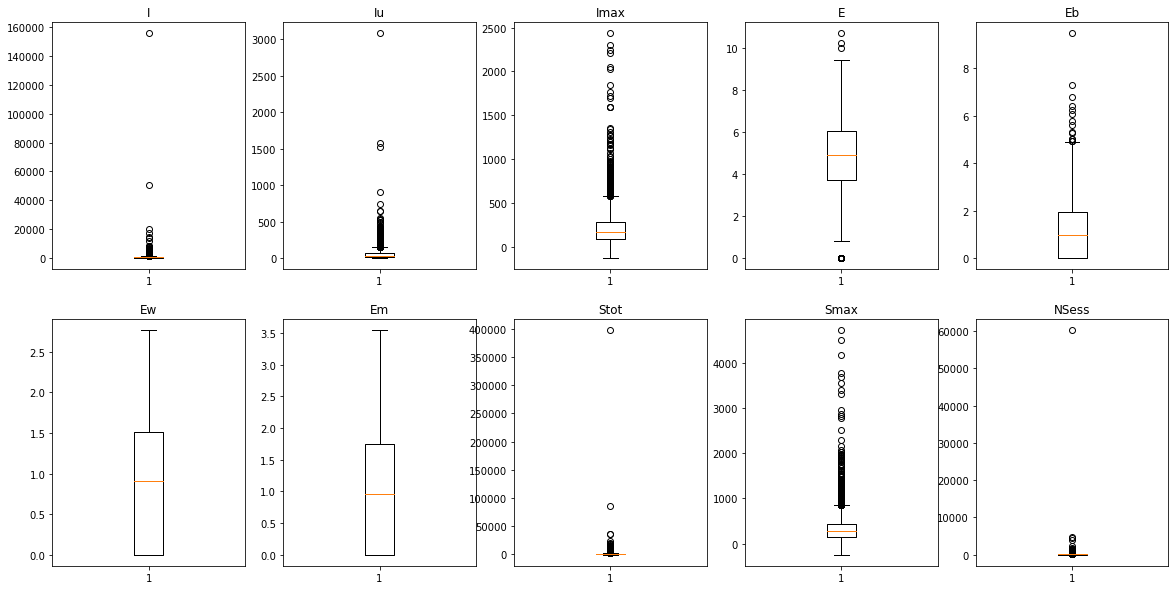

In [230]:
f, axs = plt.subplots(nrows = 2, ncols = 5, figsize=(20,10))
for i in range(len(cs.columns)):
    axs[int(i/5)][i%5].boxplot(cs[cs.columns[i]])
    axs[int(i/5)][i%5].set_title(cs.columns[i])
plt.show()

The populations of I, Iu, Imax, Stot, Smax and NSess do present outliers, we proceed by removing this employing once again the Inter-Quantile Range.

### Handling the outliers of *Customers*

We create a dataframe dedicated to containing outliers from the *Customers* dataset.

In [231]:
# creating dataframe for outliers
cs_outliers = pd.DataFrame(columns=cs.columns, index=cs.index)    
cs_outliers.drop(cs_outliers.index, inplace=True)

In utilize IQR to detect the outliers.

In [232]:
for attribute in cs.columns:
    iqr_left, iqr_right = iqr_values(cs[attribute]) # computing left and right for each attribute
    cs_outliers = cs_outliers.append(cs[(cs[attribute] < iqr_left) | (cs[attribute] > iqr_right)]) # computing list of outliers

Here we display the outliers just identified.

In [233]:
cs_outliers

,I,Iu,Imax,E,Eb,Ew,Em,Stot,Smax,NSess
CustomerID,,,,,,,,,,
17850.00,1643,22,134,4.25,4.63,0.92,0.92,4394.74,394.16,271
12583.00,3031,103,362,6.36,3.82,2.58,3.00,5267.89,737.66,203
14688.00,2312,133,251,6.72,4.05,2.12,3.02,3394.39,402.50,264
15311.00,7980,519,407,8.51,6.24,2.72,3.51,17482.90,908.38,1890
12431.00,1725,141,268,6.98,3.57,2.29,2.73,3811.15,506.40,191
...,...,...,...,...,...,...,...,...,...,...
15427.00,869,223,389,7.70,1.50,0.84,0.84,1254.35,529.92,280
15993.00,1899,306,616,8.05,2.41,1.30,1.75,2233.93,756.27,503
15444.00,742,178,557,7.42,0.91,0.91,0.91,1253.81,934.46,201


We now drop the duplicated rows within the outliers dataset. 

Such process is necessary to deal with the redundancy fueled by the process detecting outliers for one attribute at a time. A record judged as outlier for a first column could be selected again during the turn of one, or more, of the following ones.

In [234]:
# dropping redundant outliers
cs_outliers.drop_duplicates(inplace=True)
cs_outliers

,I,Iu,Imax,E,Eb,Ew,Em,Stot,Smax,NSess
CustomerID,,,,,,,,,,
17850.00,1643,22,134,4.25,4.63,0.92,0.92,4394.74,394.16,271
12583.00,3031,103,362,6.36,3.82,2.58,3.00,5267.89,737.66,203
14688.00,2312,133,251,6.72,4.05,2.12,3.02,3394.39,402.50,264
15311.00,7980,519,407,8.51,6.24,2.72,3.51,17482.90,908.38,1890
12431.00,1725,141,268,6.98,3.57,2.29,2.73,3811.15,506.40,191
...,...,...,...,...,...,...,...,...,...,...
16942.00,758,142,126,6.87,2.94,1.74,2.25,1497.61,272.60,248
16370.00,612,128,185,6.78,1.98,1.00,1.98,977.21,302.18,200
16794.00,753,136,177,6.80,2.98,2.14,2.32,1091.39,215.03,271


We now drop the remaining distinct outliers from the numerical and categorical dataframes for *Customers*.

In [235]:
# dropping outliers
cs.drop(cs_outliers.index, inplace=True)
cs_cat.drop(cs_outliers.index, inplace=True)

## Data Distributions of the Customers Dataset

### I

I
Skewness: 1.5302477168397575
Kurtosis: 2.0537594697536052


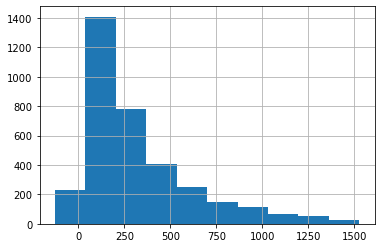

In [236]:
print('I')
print('Skewness: ' + str(cs.I.skew()))
print('Kurtosis: ' + str(cs.I.kurt()))
cs.I.hist()
plt.show()

In line with what is suggested by the values of skewness and kurtosis, the I population:
- presents a tail on its right side  
- appears pointier than the normal distribution

### Iu 

Iu
Skewness: 1.348100191264878
Kurtosis: 1.5041519106376784


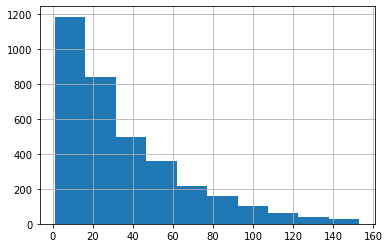

In [237]:
print('Iu')
print('Skewness: ' + str(cs.Iu.skew()))
print('Kurtosis: ' + str(cs.Iu.kurt()))
cs.Iu.hist()
plt.show()

In line with what is suggested by the values of skewness and kurtosis, and similarly to what already stated for I, the Iu population:
- presents a tail on its right side  
- appears pointier than the normal distribution

### Imax

Imax
Skewness: 0.9415842209041146
Kurtosis: 0.5072905210877394


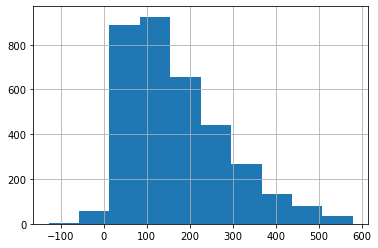

In [238]:
print('Imax')
print('Skewness: ' + str(cs.Imax.skew()))
print('Kurtosis: ' + str(cs.Imax.kurt()))
cs.Imax.hist()
plt.show()

In line with what is suggested by the values of skewness and kurtosis, the Imax population:
- presents a short tail on its right side  
- appears slightly pointier than the normal distribution

### E

E
Skewness: -0.5199126330081543
Kurtosis: -0.1387345998280729


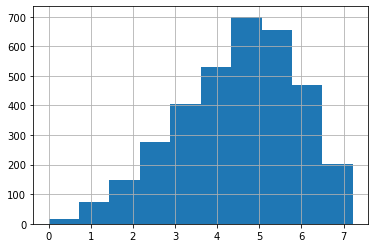

In [239]:
print('E')
print('Skewness: ' + str(cs.E.skew()))
print('Kurtosis: ' + str(cs.E.kurt()))
cs.E.hist()
plt.show()

In line with what is suggested by the values of skewness and kurtosis, the E population:
- presents a tail on its left side  
- appears slightly flatter than the normal distribution

### Eb

Eb
Skewness: 0.6577362619369818
Kurtosis: -0.5035311928438477


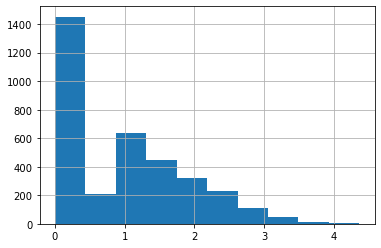

In [240]:
print('Eb')
print('Skewness: ' + str(cs.Eb.skew()))
print('Kurtosis: ' + str(cs.Eb.kurt()))
cs.Eb.hist()
plt.show()

In line with what is suggested by the values of skewness and kurtosis, the Eb population:
- presents a tail on its right side  
- appears slightly flatter than the normal distribution

### Ew

Ew
Skewness: 0.5399349274560734
Kurtosis: -0.9813287837683076


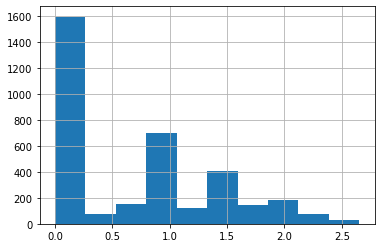

In [241]:
print('Ew')
print('Skewness: ' + str(cs.Ew.skew()))
print('Kurtosis: ' + str(cs.Ew.kurt()))
cs.Ew.hist()
plt.show()

In line with what is suggested by the values of skewness and kurtosis, the Ew population:
- presents a tail on its right side  
- appears slightly flatter than the normal distribution

### Em

Em
Skewness: 0.5879262526829895
Kurtosis: -0.8102200434902613


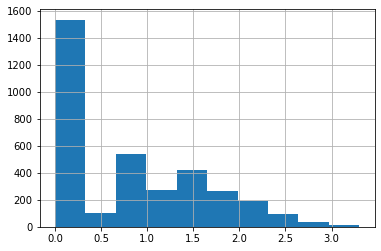

In [242]:
print('Em')
print('Skewness: ' + str(cs.Em.skew()))
print('Kurtosis: ' + str(cs.Em.kurt()))
cs.Em.hist()
plt.show()

In line with what is suggested by the values of skewness and kurtosis, the Em population:
- presents a tail on its right side  
- appears slightly flatter than the normal distribution

### Stot

Stot
Skewness: 1.5520605686778441
Kurtosis: 2.064043381716731


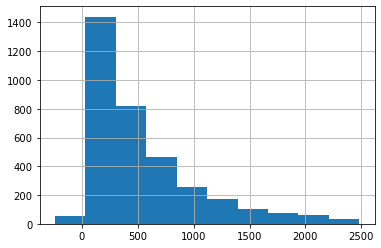

In [243]:
print('Stot')
print('Skewness: ' + str(cs.Stot.skew()))
print('Kurtosis: ' + str(cs.Stot.kurt()))
cs.Stot.hist()
plt.show()

In line with what is suggested by the values of skewness and kurtosis, the Stot population:
- presents a tail on its right side  
- appears pointier than the normal distribution

### Smax

Smax
Skewness: 0.9149908914690185
Kurtosis: 0.5815767783466219


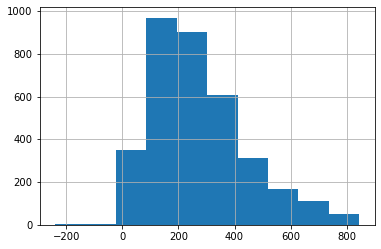

In [244]:
print('Smax')
print('Skewness: ' + str(cs.Smax.skew()))
print('Kurtosis: ' + str(cs.Smax.kurt()))
cs.Smax.hist()
plt.show()

In line with what is suggested by the values of skewness and kurtosis, the Smax population:
- presents a short tail on its right side  
- appears slightly pointier than the normal distribution

### NSess

NSess
Skewness: 1.4450629870369525
Kurtosis: 1.7713568641779727


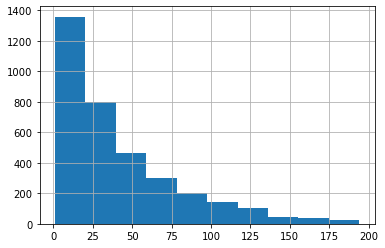

In [245]:
print('NSess')
print('Skewness: ' + str(cs.NSess.skew()))
print('Kurtosis: ' + str(cs.NSess.kurt()))
cs.NSess.hist()
plt.show()

In line with what is suggested by the values of skewness and kurtosis, the NSess population:
- presents a tail on its right side  
- appears pointier than the normal distribution

## Correlations among the Attributes of Customers

We now compute the correlation matrix related to the numerical attributes of the *Customers* dataset.

In [246]:
mat = cs.corr()

The matrix above can be also used as a parameter for the seaborn function **heatmap()**. This will plot a matrix where the color of the cell corresponds to the intensity of the correlation among the attributes. 

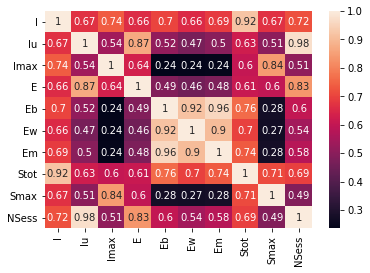

In [247]:
sn.heatmap(mat, annot=True)
plt.show()

We proceed by discussing some of the highest correlations among the attributes of the dataset:
- the high correlations between **I** and **Stot**, and **Imax** and **Smax**, refer to the increase in cost being obviously proportional to the number of products bought

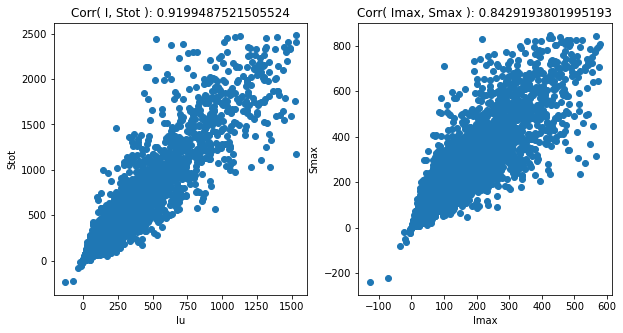

In [248]:
f, axs = plt.subplots(nrows = 1, ncols = 2, figsize=(10,5))
axs[0].scatter(cs.I, cs.Stot)
axs[0].set_title('Corr( I, Stot ): ' + str(cs.I.corr(cs.Stot)))
axs[0].set_xlabel('Iu')
axs[0].set_ylabel('Stot')
axs[1].scatter(cs.Imax, cs.Smax)
axs[1].set_title('Corr( Imax, Smax ): ' + str(cs.Imax.corr(cs.Smax)))
axs[1].set_xlabel('Imax')
axs[1].set_ylabel('Smax')
plt.show()

- the correlation between **Iu** and **E** is expected due to both attributes being an indicator of variety (and disorder) within the customer's choice of products

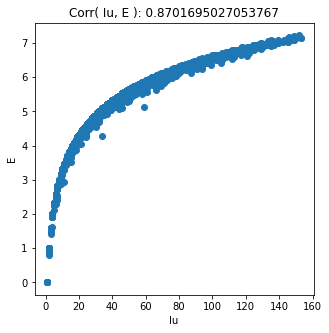

In [249]:
f, axs = plt.subplots(nrows = 1, ncols = 1, figsize=(5,5))
axs.scatter(cs.Iu, cs.E)
axs.set_title('Corr( Iu, E ): ' + str(cs.Iu.corr(cs.E)))
axs.set_xlabel('Iu')
axs.set_ylabel('E')
plt.show()

- the very high correlation between **Iu** and **NSess**, as the one between **E** and **NSess**, highlights a type of non-routine spending, new sessions often lead to the purchase of new types of products

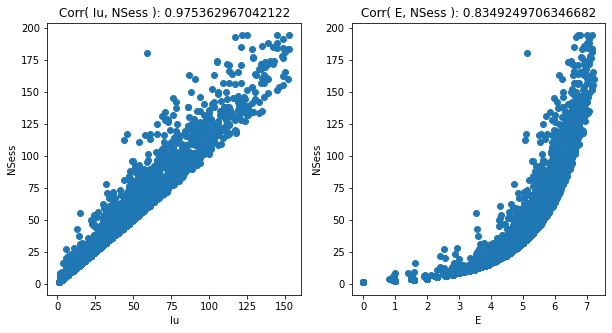

In [250]:
f, axs = plt.subplots(nrows = 1, ncols = 2, figsize=(10,5))
axs[0].scatter(cs.Iu, cs.NSess)
axs[0].set_title('Corr( Iu, NSess ): ' + str(cs.Iu.corr(cs.NSess)))
axs[0].set_xlabel('Iu')
axs[0].set_ylabel('NSess')
axs[1].scatter(cs.E, cs.NSess)
axs[1].set_title('Corr( E, NSess ): ' + str(cs.E.corr(cs.NSess)))
axs[1].set_xlabel('E')
axs[1].set_ylabel('NSess')
plt.show()

- the high correlations between the attributes **Eb**, **Ew** and **Em** is expected due to their very similar nature  

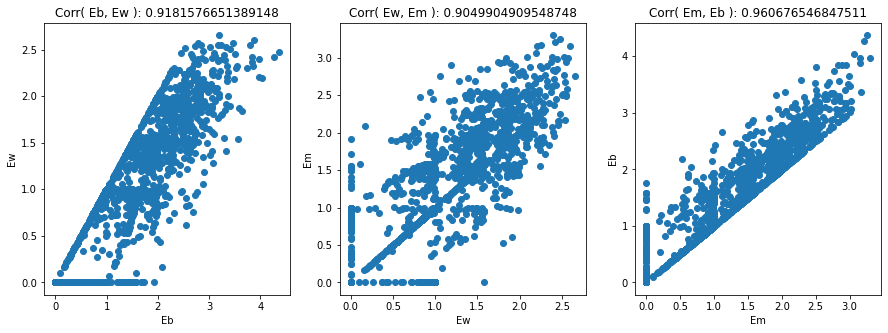

In [251]:
f, axs = plt.subplots(nrows = 1, ncols = 3, figsize=(15,5))
axs[0].scatter(cs.Eb, cs.Ew)
axs[0].set_title('Corr( Eb, Ew ): ' + str(cs.Eb.corr(cs.Ew)))
axs[0].set_xlabel('Eb')
axs[0].set_ylabel('Ew')
axs[1].scatter(cs.Ew, cs.Em)
axs[1].set_title('Corr( Ew, Em ): ' + str(cs.Ew.corr(cs.Em)))
axs[1].set_xlabel('Ew')
axs[1].set_ylabel('Em')
axs[2].scatter(cs.Em, cs.Eb)
axs[2].set_title('Corr( Em, Eb ): ' + str(cs.Em.corr(cs.Eb)))
axs[2].set_xlabel('Em')
axs[2].set_ylabel('Eb')
plt.show()

## Data Visualization on the Customers Dataset

## Extra: Storing the datasets in csv files

In [252]:
cs.to_csv(path_or_buf='dataset/customers_num.csv')
cs_cat.to_csv(path_or_buf='dataset/customers_cat.csv')